In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks', palette='Set2')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,RobustScaler
import category_encoders as ce

# model selection & hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold

# model regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import catboost
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor

# metric regression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import time
import warnings
warnings.filterwarnings('ignore')


**Get stored dataframe**

In [2]:
%store -r df
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi
...,...,...,...,...,...,...,...,...,...,...
108535,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,vw
108536,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,vw
108537,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,vw
108538,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,vw


# Cleaning Data

In [3]:
def proportionByBrand(i_df, title):
    plt.figure(figsize=(15,8))
    proportion = i_df['brand'].value_counts().reset_index()
    proportion = proportion.rename(columns = {'index': 'brand', 'brand':'count'})
    sns.barplot(x='brand', y='count', data=proportion)
    for i in range(len(proportion)): plt.text(i, (proportion['count'][i]), int(proportion['count'][i]), ha='center')
    plt.title(title)
    plt.show()
        

## Identifying & Handling Duplicate Data

In [4]:
duplicated_df = df[df.duplicated(keep='first')==True]
duplicated_df.shape

(2273, 10)

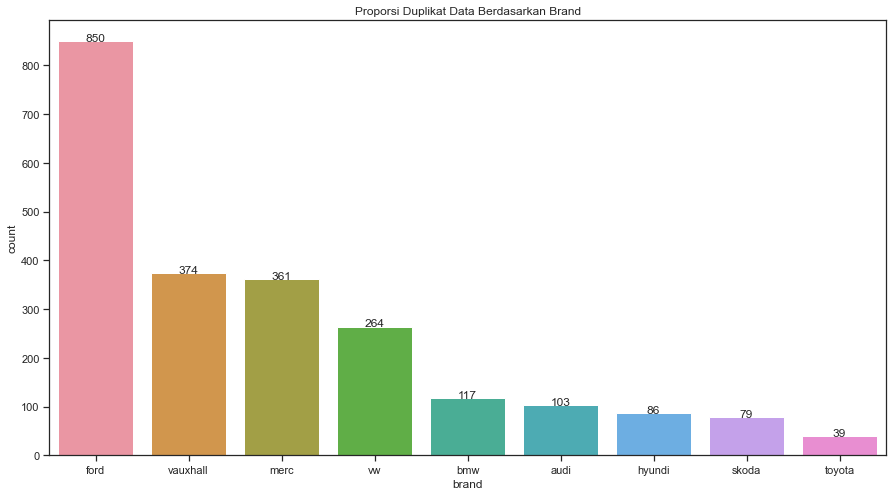

In [5]:
proportionByBrand(duplicated_df, 'Proporsi Duplikat Data Berdasarkan Brand')

1. Terdapat 2273 baris data duplicat atau sekitar 2.09% dari keseluruhan dataset
2. Brand mobil ford memiliki jumlah data duplikat terbanyak yaitu sejumlah 850 baris data atau sekitar 37.40% dari keseluruhan data duplikat

Untuk menghindari terjadi overfitting akibat data duplikat ini, maka kita perlu melakukan drop data

In [6]:
df=df.drop_duplicates(keep='first')
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi
...,...,...,...,...,...,...,...,...,...,...
108535,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,vw
108536,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,vw
108537,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,vw
108538,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,vw


Setelah data yang duplikat di didrop, sekarang kita memiliki 106267 baris data didataset kita

## Identifying & Handling Anomali Data

Pada tahap **Data Understanding** kita mendapati dua anomali data, yaitu :
1. Anomali pada variable Year, dimana max year = 2060
2. Anomali pada variable engineSize, dimana min engineSize = 0

**Anomali pada Variable Year**

In [7]:
df[df['year'] == 2060]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
48528,Fiesta,2060,6495,Automatic,54807,Petrol,205.0,42.8,1.4,ford


Dari informasi diatas, kita mendapati bahwa hanya ada satu data yang memiliki nilai year = 2060. Maka kita bisa melakukan drop data untuk menghilangkan anomali data tersebut.

In [8]:
df = df.drop(df[df['year'] == 2060].index)

In [9]:
df.shape

(106266, 10)

setelah data anomali tersebut di drop, sekarang kita memiliki 106266 baris data didataset kita

**Anomali pada Variable engineSize**

In [10]:
zeroEngineSize_df = df[df['engineSize'] == 0]
zeroEngineSize_df.shape

(281, 10)

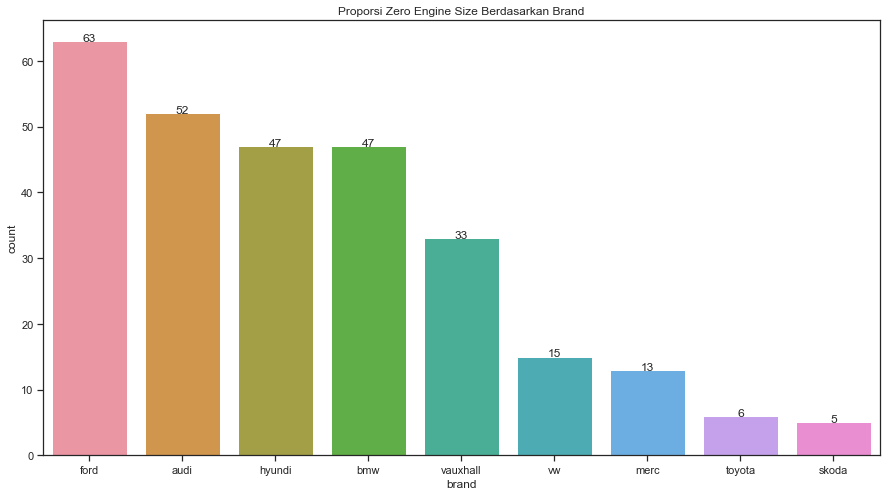

In [11]:
proportionByBrand(zeroEngineSize_df, "Proporsi Zero Engine Size Berdasarkan Brand" )

1. Terdapat 281 baris data yang memiliki engineSize = 0 didataset kita
2. Brand mobil ford memiliki jumlah data engineSize = 0 terbanyak sejumlah 63 data atau sekitar 22.42% dari keseluruhan baris data yang memiliki engineSize = 0

Karena jumlah datanya cukup banyak, maka kita akan menganggap data yang memiliki engineSize = 0 sebagai missing value

## Identifying & Handling Missing Value

Kita akan mencoba mengisi data missing value dengan mengambil data dari mobil yang memiliki kriteria yang sama. 

In [12]:
def fillMVByCriteria(criteria, mv_df, mv_col):
    # looping dataframe menggunakan indexnya
    for mv_index in mv_df.index:
        q = ''
        order = 1

        # DataFrame.query memiliki argumen expr, yang kita bisa isi dengan query string
        # maka kita harus mengubah query yang kita inginkan menjadi bentuk string
        for j in criteria:
            # untuk data yang tipenya string, harus ditambahkan tanda kutip
            if type(mv_df.loc[mv_index][j]) == np.str:
                q += j + ' == "' + mv_df.loc[mv_index][j] + '"'
            else:
                q += j + ' == ' + np.str(mv_df.loc[mv_index][j])

            # menambahkan `and` pada query string kita
            if order < len(criteria):
                q += ' and '
                order += 1


        # simpan dataframe hasil query dengan kriteria yang mirip tersebut
        similar_criteria = df.dropna().query(q)

        # jika dataframe diatas tidak kosong
        if similar_criteria.empty == False:
            for k in mv_col:
                # ambil nilai yang frequensinya terbanyak
                df.loc[mv_index, k] = similar_criteria[k].value_counts().index[0]
            

**Missing Value pada Variable Engine Size**

Kriteria yang akan kita gunakan untuk mengisi missing value pada engine size ada adalah model, year, transmission & fuel type

In [13]:
fillMVByCriteria(['model', 'year', 'transmission', 'fuelType'], df[df['engineSize'] == 0], ['engineSize'])

In [14]:
df[df['engineSize'] == 0].shape

(63, 10)

Kita berhasil mengisi 218 baris data sehingga hanya tersisa 63 data yang memiliki engineSize = 0 . Data yang masih 0 ini akan kita biarkan sebagai penanda data missing value.

**Missing Value pada Variable Tax & MPG**

Pada tahap **Data Understanding** kita mendapati jumlah data Non-Null pada kolom tax & mpg berbeda dengan kolom lainnya. Maka kita akan coba hitung jumlah data NaN yang berada di kolom tersebut.

In [15]:
df['tax'].isna().sum()

8555

In [16]:
df['mpg'].isna().sum()

8555

In [17]:
# cek apakah tax & mpg yang memiliki data NaN memiliki index yang sama
tax_index = list(df['tax'].isna().index)
mpg_index = list(df['mpg'].isna().index)
tax_index == mpg_index

True

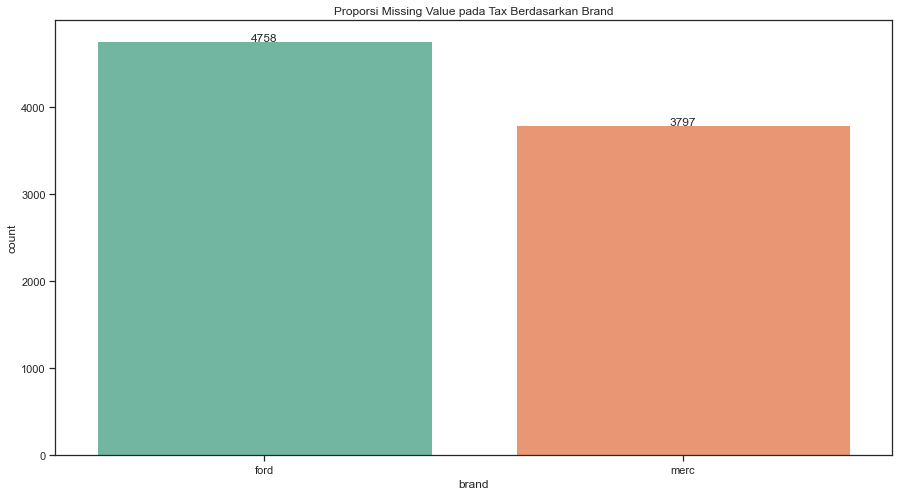

In [18]:
proportionByBrand(df[df['tax'].isna()], "Proporsi Missing Value pada Tax Berdasarkan Brand" )

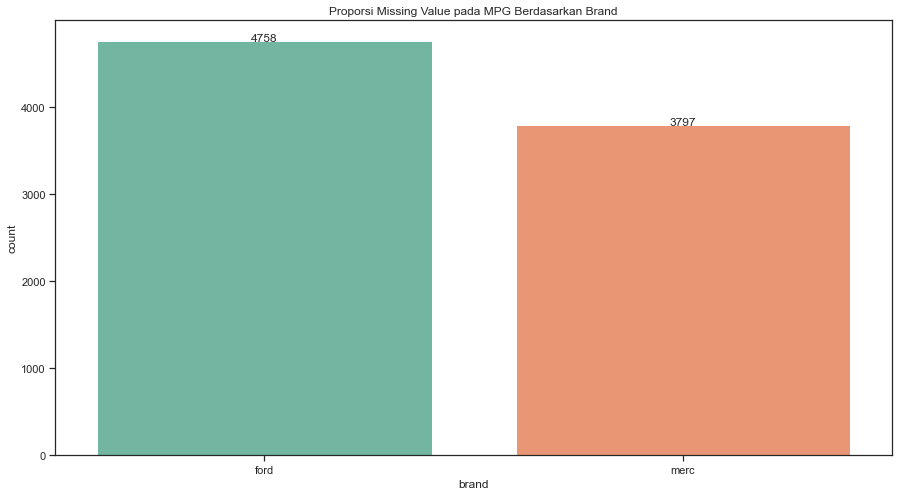

In [19]:
proportionByBrand(df[df['mpg'].isna()], "Proporsi Missing Value pada MPG Berdasarkan Brand" )

Ternyata memang benar ada 8555 baris data NaN yang berada dikolom tersebut dan indexnya identical. Untuk selanjutnya kita akan mencoba mengisi data NaN tersebut dengan kriteria mobil: model, year, transmission, fuel type & engineSize

In [20]:
fillMVByCriteria(['model', 'year', 'transmission', 'fuelType', 'engineSize'], df[df['tax'].isna()==True], ['tax', 'mpg'])


In [21]:
df.isna().sum()

model            0
year             0
price            0
transmission     0
mileage          0
fuelType         0
tax             28
mpg             28
engineSize       0
brand            0
dtype: int64

Setelah dicek, ternyata masih ada 28 data yang missing value, sisa data yang missing value ini akan diisi dengan 0 value untuk menandai missing valuenya

In [22]:
df = df.fillna(0)

In [23]:
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
brand           0
dtype: int64

Karena kita mengisi missing value dengan kriteria mobil yang mirip, kemungkinan terjadinya duplikat data sangat tinggi, maka kita perlu untuk mengecek ulang data yang duplikat dan drop data tersebut

In [24]:
df[df.duplicated(keep='first')==True]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
7667,Q3,2020,33990,Automatic,1500,Diesel,145.0,47.1,2.0,audi
30827,Focus,2017,18499,Manual,13063,Petrol,145.0,41.5,2.0,ford
30834,Focus,2019,18990,Manual,8400,Petrol,145.0,60.1,1.0,ford
30848,Focus,2017,14960,Manual,23554,Petrol,145.0,41.5,2.0,ford
30850,Focus,2019,17970,Manual,10985,Diesel,145.0,74.3,1.5,ford
...,...,...,...,...,...,...,...,...,...,...
66730,C Class,2019,23444,Automatic,10284,Diesel,145.0,61.4,2.0,merc
66733,C Class,2019,27999,Automatic,6537,Petrol,145.0,44.1,2.0,merc
66734,C Class,2019,24999,Automatic,6064,Diesel,145.0,61.4,2.0,merc
66739,C Class,2019,30399,Automatic,5000,Diesel,145.0,61.4,2.0,merc


Terdapat 3977 data yang duplikat, maka data tersebut akan kita drop

In [25]:
df=df.drop_duplicates(keep='first')
df.shape

(102289, 10)

Sehingga sekarang kita memiliki 102289 baris data didataset kita dari sebelumnya 108540 baris data. Proses cleaning data ini membuat kita melakukan drop data sebanyak 6251 baris data atau sekitar 5.76% dari jumlah baris data di dataset awal yang kita miliki

# Model Benchmark

## Encoding Categorical Data

In [26]:
transformer = ColumnTransformer([
    ('catboost encoder', ce.cat_boost.CatBoostEncoder(), ['model', 'transmission', 'fuelType', 'brand']),
], remainder='passthrough')

## Casting Data Type

In [27]:
# ubah data type object menjadi category untuk model catboost
df['model']=df['model'].astype('category')
df['transmission']=df['transmission'].astype('category')
df['fuelType']=df['fuelType'].astype('category')
df['brand']=df['brand'].astype('category')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102289 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   model         102289 non-null  category
 1   year          102289 non-null  int64   
 2   price         102289 non-null  int64   
 3   transmission  102289 non-null  category
 4   mileage       102289 non-null  int64   
 5   fuelType      102289 non-null  category
 6   tax           102289 non-null  float64 
 7   mpg           102289 non-null  float64 
 8   engineSize    102289 non-null  float64 
 9   brand         102289 non-null  category
dtypes: category(4), float64(3), int64(3)
memory usage: 6.0 MB


## Splitting Data

In [29]:
x = df.drop(columns=['price'])
y = df['price']

In [30]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    random_state=2020
)

## Model Comparison

In [31]:
modelLinReg = LinearRegression()
modelRidge = Ridge()
modelLasso = Lasso()
modelTree = DecisionTreeRegressor(random_state=2020)
modelKNN = KNeighborsRegressor()
modelRF = RandomForestRegressor(random_state=2020)
modelXGB = XGBRegressor(random_state=2020)
modelCB = CatBoostRegressor(random_state=2020, silent=True)

# catboost menerima data categorical tanpa perlu diencoding
# kita hanya perlu menambah parameter 'cat_features' yang diisi dengan list nama kolom data kategorikal
# untuk selanjutnya kita akan menyebut model ini sebagai catboost category
cat_features=['model', 'transmission', 'fuelType', 'brand']
modelCBCat = CatBoostRegressor(random_state=2020, silent=True, cat_features=cat_features)

In [32]:
ml_models = [
    modelLinReg, 
    modelRidge,
    modelLasso,
    modelTree,
    modelKNN,
    modelRF,
    modelXGB,
    modelCB,
    'modelCBCat'
]

In [33]:
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

mae_mean = []
mae_std = []
mape_mean = []
mape_std = []
exec_time = []

# loop per-model
for i in ml_models:
    start_time = time.time()
    mae_scores = []
    mape_scores = []
    
    # loop sebanyak jumlah fold yang kita tentukan diparameter n_splits
    for train_index, val_index in kf.split(x_train):
        # bagi data train menjadi, data train dan data validation
        x1_train, x_val = x_train.iloc[train_index], x_train.iloc[val_index]
        y1_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
          
        if i == 'modelCBCat':
            # untuk catboost category tidak perlu menggunakan pipeline, karena data tidak perlu di encoding
            estimator = modelCBCat
        else:
            estimator = Pipeline([
                ('preprocess', transformer),
                ('model', i)
            ])
        
        estimator.fit(x1_train, y1_train)
        mae_scores.append(mean_absolute_error(y_val, estimator.predict(x_val)))
        mape_scores.append(mean_absolute_percentage_error(y_val, estimator.predict(x_val)) * 100)

    mae_mean.append(np.mean(mae_scores))
    mae_std.append(np.std(mae_scores))
    mape_mean.append(np.mean(mape_scores))
    mape_std.append(np.std(mape_scores))
    exec_time.append(time.time() - start_time)
    

In [34]:
modelBenchmark=pd.DataFrame({
    'model': ['linreg', 'ridge', 'lasso', 'tree', 'knn', 'rf', 'xgb', 'cb', 'cbcat'],
    'mae_score_mean': mae_mean,
    'mae_score_std': mae_std,
    'mape_score_mean': mape_mean,
    'mape_score_std': mape_std,
    'execution_time': exec_time
})
modelBenchmark

,model,mae_score_mean,mae_score_std,mape_score_mean,mape_score_std,execution_time
0,linreg,2528.689924,19.586240,19.645696,0.440782,2.964075
1,ridge,2528.664110,19.584679,19.645304,0.440768,2.645501
2,lasso,2528.451494,19.575456,19.641197,0.440561,3.101865
3,tree,1703.585559,12.303576,10.490799,0.077597,5.682352
4,knn,2388.313310,13.877058,15.292575,0.167353,8.270105
5,rf,1237.804430,9.602690,7.625938,0.026406,257.786078
6,xgb,1322.499494,8.781922,8.268822,0.133981,40.645085
7,cb,1284.295455,8.005645,7.997173,0.053308,61.105061
8,cbcat,1273.539545,6.180566,7.904719,0.074063,234.785897


Dari tabel diatas, kita dapat melihat terdapat 3 model dengan performa terbaik yaitu Random Forest, Catboost & Catboost Category.
1. Random Forest memiliki MAE & MAPE score terendah dengan persentase kesalahan prediksi sebesar 7.62% tetapi execution timenya paling lama diantara model lainnya
2. Catboost memiliki MAE & MAPE score tertinggi diantara 3 model dengan performa terbaik ini yaitu dengan persentase kesalahan prediksi sebesar 8% tetapi execution timenya paling cepat diatara ketiga model dengan persentase terbaik itu
3. Catboost Category memiliki MAE & MAPE score yang lebih rendah dari Catboot dengan persentase kesalahan prediksi sebesar 7.9% dan juga yang paling stabil diantara model lainnya tetapi execution timenya cukup lama

Karena persentase kesalahan prediksi diantara tiga model terbaik ini sangat berdekatan, maka kita akan memilih model yang memiliki execution time tercepat yaitu Catboost. 

**save data df to be used on other file**

In [35]:
df_clean = df

%store df_clean
%store x_train
%store x_test
%store y_train
%store y_test
%store transformer

Stored 'df_clean' (DataFrame)
Stored 'x_train' (DataFrame)
Stored 'x_test' (DataFrame)
Stored 'y_train' (Series)
Stored 'y_test' (Series)
Stored 'transformer' (ColumnTransformer)
